---

_You are currently looking at **version 1.5** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

# Pandas use assignment: data cleaning, merging, and profiling

#### Check Python and Import search directories, Install and Import needed modules

In [ ]:
import sys

In [ ]:
print(sys.executable)

In [ ]:
print(sys.path)

In [ ]:
!pip3 install xlrd
!pip3 install pandas
!pip3 install numpy
!pip3 install re
!pip3 install matplotlib

In [ ]:
!pip3 install --upgrade pip

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import re
from pandas import ExcelWriter
from pandas import ExcelFile
from functools import reduce
import operator

### Data Preperation
1) Load the energy data from the file `Energy Indicators.xls`, which is a list of indicators of [energy supply and renewable electricity production](Energy%20Indicators.xls) from the [United Nations](http://unstats.un.org/unsd/environment/excel_file_tables/2013/Energy%20Indicators.xls) for the year 2013, and should be put into a DataFrame with the variable name of **energy**.

Remaining column labels should be:

`['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']`

2) Convert `Energy Supply` to gigajoules (there are 1,000,000 gigajoules in a petajoule). For all countries which have missing data (e.g. data with "...") make sure this is reflected as `np.NaN` values.

3) Rename the following list of countries (for use in later questions):

```"Republic of Korea": "South Korea",
"United States of America": "United States",
"United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
"China, Hong Kong Special Administrative Region": "Hong Kong"```

4) Remove numbers and/or parenthesis from country names that contain them, e.g. 

`'Bolivia (Plurinational State of)'` should be `'Bolivia'`, 

`'Switzerland17'` should be `'Switzerland'`.

<br>

5) Next, load the GDP data from the file `world_bank.csv`, which is a csv containing countries' GDP from 1960 to 2015 from [World Bank](http://data.worldbank.org/indicator/NY.GDP.MKTP.CD). Call this DataFrame **GDP**. 

6) Rename the following list of countries:

```"Korea, Rep.": "South Korea", 
"Iran, Islamic Rep.": "Iran",
"Hong Kong SAR, China": "Hong Kong"```

<br>

7) Finally, load the [Sciamgo Journal and Country Rank data for Energy Engineering and Power Technology](http://www.scimagojr.com/countryrank.php?category=2102) from the file `scimagojr-3.xlsx`, which ranks countries based on their journal contributions in the aforementioned area. Call this DataFrame **ScimEn**.

8) Join the three datasets: GDP, Energy, and ScimEn into a new dataset (using the intersection of country names). Use only the last 10 years (2006-2015) of GDP data and only the top 15 countries by Scimagojr 'Rank' (Rank 1 through 15). 

The index of this DataFrame should be the name of the country, and the columns should be ['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations',
       'Citations per document', 'H index', 'Energy Supply',
       'Energy Supply per Capita', '% Renewable', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015'].

*This function should return a DataFrame with 20 columns and 15 entries.*

### Read-in and clean energy dataset

In [6]:
def energy():
    energy = pd.ExcelFile('Energy Indicators.xls')

    # parsing first (index: 0) sheet
    total_rows = energy.book.sheet_by_index(0).nrows
    #print(f"total rows:{total_rows}")
    ##skiprows indexing starts at 1
    header = 17
    ## 244 instead of the 245 rows of interest (with header/skiprows exception) since indexing starts at 0
    nrows = 244 - header
    footer = total_rows - 244
    #print(f"header:{header}")
    #print(f"nrows:{nrows}")
    #print(f"footer:{footer}")
# (-1) in order to allow for the column label row
    skipfooter = total_rows - nrows - header - 1
    #print(f"skipfooter:{skipfooter}")
    energy = energy.parse(0, skiprows = header, skipfooter = skipfooter)    
    energy = energy.iloc[:, 2:].copy()
#header indexing starts at 0
    #print(energy.head())
    
    column_names = ['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']
    energy.columns = column_names
    energy = energy.replace("...",np.nan)
    energy['Energy Supply']= energy['Energy Supply']*1000000
    
    energy['Country'] = energy['Country'].map({'Republic of Korea': 'South Korea', "United States of America20": "United States", "United Kingdom of Great Britain and Northern Ireland19": "United Kingdom", "China, Hong Kong Special Administrative Region3": "Hong Kong"}).fillna(energy['Country'])
    #print('Hong Kong' in energy['Country'].unique())
    #print(energy['Country'])
    #preceeding mapper replaces following clunky code:

    #i = 0
    #for country in energy['Country']:
     #   if country == "Republic of Korea":
      #      energy['Country'][i] = "South Korea"
       # elif country == "United States of America20":
        #    energy['Country'][i] = "United States"
        #elif country == "United Kingdom of Great Britain and Northern Ireland19":
         #   energy['Country'][i] = "United Kingdom"
        #elif country == "China, Hong Kong Special Administrative Region3":
         #   energy['Country'][i] = "Hong Kong"
        #i+= 1
#print(energy["Country"])

    energy['Country'] = energy['Country'].apply(lambda x: ''.join([e for e in x if not e.isdigit()])).fillna(energy['Country'])
    #preceeding lambda replaces following code:
    
    #i = 0
    #for country in energy['Country']:
     #   L = ''.join([c for c in country if not c.isdigit()])
    ##L = country.str.findall('(\d+)', expand=False).astype(int).tostring()
     #   energy['Country'][i] = energy['Country'][i].replace(country, L)
      #  i+=1
    
    ## replace '(' and ')' with empty string (i.e., eliminate these special chars) from country names, if present
    energy['Country'] = energy['Country'].apply(lambda x: re.sub(r"\s\(.*\)", "", x))
    #print('Bolivia' in energy['Country'].unique())
    return energy
energy()

,Country,Energy Supply,Energy Supply per Capita,% Renewable
0,Afghanistan,3.210000e+08,10.0,78.669280
1,Albania,1.020000e+08,35.0,100.000000
2,Algeria,1.959000e+09,51.0,0.551010
3,American Samoa,NaN,NaN,0.641026
4,Andorra,9.000000e+06,121.0,88.695650
...,...,...,...,...
222,Viet Nam,2.554000e+09,28.0,45.321520
223,Wallis and Futuna Islands,0.000000e+00,26.0,0.000000
224,Yemen,3.440000e+08,13.0,0.000000
225,Zambia,4.000000e+08,26.0,99.714670


### Read-in and clean GDP dataset

In [7]:
def gdp():
    GDP = pd.read_csv('world_bank.csv', header = 4) 
    #GDP['Country Name'] = GDP['Country Name'].map({"Korea, Rep.": 'South Korea', "Iran, Islamic Rep.": 'Iran', "Hong Kong SAR, China": 'Hong Kong'}).fillna(GDP['Country Name'])
    countries_dict = {"Korea, Rep.": 'South Korea', "Iran, Islamic Rep.": 'Iran', "Hong Kong SAR, China": 'Hong Kong'}
    #no need for fillna call at end of method chain when using conditional lambda inside map call.
    GDP['Country Name'] = GDP['Country Name'].map(lambda x: x.replace(x, countries_dict[x] if x in countries_dict else x))
    #print('Iran' in GDP['Country Name'].unique())
    #preceeding lambda replaces the following otherwise lengthier code:
    
    #for i, row in GDP.iterrows():
     #   if row[0] == "Korea, Rep.":
      #      GDP['Country Name'][i] = 'South Korea'
        ##print (i, row)
        #if row[0] == "Iran, Islamic Rep.":
         #   GDP['Country Name'][i] = 'Iran'  
        #if row[0] == "Hong Kong SAR, China":
         #   GDP["Country Name"][i] = 'Hong Kong'

    GDP.rename(columns = {'Country Name': 'Country'}, inplace = True)
    GDP = GDP.loc[:, "Country":"Country Code"].join(GDP.loc[:,'2006':'2015'])
    GDP.drop(["Country Code"], axis = 1, inplace = True)
    
    return GDP
gdp()

,Country,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,NaN,NaN,NaN,NaN,2.467704e+09,NaN,NaN,NaN,NaN,NaN
1,Andorra,4.018196e+09,4.021331e+09,3.675728e+09,3.535389e+09,3.346317e+09,3.185605e+09,3.129538e+09,3.127550e+09,NaN,NaN
2,Afghanistan,1.030523e+10,1.172119e+10,1.214448e+10,1.469733e+10,1.593680e+10,1.691113e+10,1.935220e+10,1.973134e+10,1.999032e+10,2.029415e+10
3,Angola,5.581103e+10,6.842044e+10,7.787420e+10,7.975320e+10,8.247091e+10,8.570262e+10,9.012096e+10,9.626143e+10,1.008863e+11,1.039106e+11
4,Albania,9.771760e+09,1.034829e+10,1.112752e+10,1.150029e+10,1.192695e+10,1.223109e+10,1.240477e+10,1.254247e+10,1.279331e+10,1.312082e+10
...,...,...,...,...,...,...,...,...,...,...,...
259,"Yemen, Rep.",2.672565e+10,2.761787e+10,2.872656e+10,2.991436e+10,3.090675e+10,2.624342e+10,2.689160e+10,2.800914e+10,NaN,NaN
260,South Africa,3.402852e+11,3.585261e+11,3.699668e+11,3.642764e+11,3.753494e+11,3.874074e+11,3.960071e+11,4.047682e+11,4.110369e+11,4.163117e+11
261,"Congo, Dem. Rep.",1.650894e+10,1.754232e+10,1.863448e+10,1.916651e+10,2.052329e+10,2.193213e+10,2.350200e+10,2.550050e+10,2.778776e+10,2.970961e+10
262,Zambia,1.440569e+10,1.560892e+10,1.682234e+10,1.837342e+10,2.026555e+10,2.140358e+10,2.302438e+10,2.420595e+10,2.542227e+10,2.624127e+10


### Read-in SciMen dataset then merge all datasets

In [8]:


def scimen():
    
    ScimEn = pd.read_excel("scimagojr-3.xlsx")
    
    return ScimEn

#print(ScimEn)
#print(GDP['Country'][80:])

#df.drop(df.columns.to_series()["D":"R"], axis=1)
#join the three datasets: GDP, Energy, and ScimEn into a new dataset (using the intersection of country names). Use only the last 10 years (2006-2015) of GDP data and only the top 15 countries by Scimagojr 'Rank' (Rank 1 through 15).

#pd.merge(energy, GDP, ScimEn, how = 'inner', )
#print(df_final.size, df_final.shape, df_final.ndim)


def answer_one():
    
    energy1, GDP, ScimEn = energy(),gdp(),scimen()
    #print(ScimEn.columns, GDP.columns, energy1.columns)
    dfs = [ScimEn, energy1, GDP]
    #subsequent calls to merge (reduce) allows for joining across tables on specified key(s)
    df_final = reduce(lambda left,right: pd.merge(left,right,on='Country', how = 'inner'), dfs)
    df_final.set_index("Country", inplace = True)
    df_final = df_final[df_final['Rank'] <= 15]
    
    return df_final

answer_one()

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,Energy Supply,Energy Supply per Capita,% Renewable,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,
China,1,127050,126767,597237,411683,4.70,138,1.271910e+11,93.0,19.754910,3.992331e+12,4.559041e+12,4.997775e+12,5.459247e+12,6.039659e+12,6.612490e+12,7.124978e+12,7.672448e+12,8.230121e+12,8.797999e+12
United States,2,96661,94747,792274,265436,8.20,230,9.083800e+10,286.0,11.570980,1.479230e+13,1.505540e+13,1.501149e+13,1.459484e+13,1.496437e+13,1.520402e+13,1.554216e+13,1.577367e+13,1.615662e+13,1.654857e+13
Japan,3,30504,30287,223024,61554,7.31,134,1.898400e+10,149.0,10.232820,5.496542e+12,5.617036e+12,5.558527e+12,5.251308e+12,5.498718e+12,5.473738e+12,5.569102e+12,5.644659e+12,5.642884e+12,5.669563e+12
United Kingdom,4,20944,20357,206091,37874,9.84,139,7.920000e+09,124.0,10.600470,2.419631e+12,2.482203e+12,2.470614e+12,2.367048e+12,2.403504e+12,2.450911e+12,2.479809e+12,2.533370e+12,2.605643e+12,2.666333e+12
Russian Federation,5,18534,18301,34266,12422,1.85,57,3.070900e+10,214.0,17.288680,1.385793e+12,1.504071e+12,1.583004e+12,1.459199e+12,1.524917e+12,1.589943e+12,1.645876e+12,1.666934e+12,1.678709e+12,1.616149e+12
Canada,6,17899,17620,215003,40930,12.01,149,1.043100e+10,296.0,61.945430,1.564469e+12,1.596740e+12,1.612713e+12,1.565145e+12,1.613406e+12,1.664087e+12,1.693133e+12,1.730688e+12,1.773486e+12,1.792609e+12
Germany,7,17027,16831,140566,27426,8.26,126,1.326100e+10,165.0,17.901530,3.332891e+12,3.441561e+12,3.478809e+12,3.283340e+12,3.417298e+12,3.542371e+12,3.556724e+12,3.567317e+12,3.624386e+12,3.685556e+12
India,8,15005,14841,128763,37209,8.58,115,3.319500e+10,26.0,14.969080,1.265894e+12,1.374865e+12,1.428361e+12,1.549483e+12,1.708459e+12,1.821872e+12,1.924235e+12,2.051982e+12,2.200617e+12,2.367206e+12
France,9,13153,12973,130632,28601,9.93,114,1.059700e+10,166.0,17.020280,2.607840e+12,2.669424e+12,2.674637e+12,2.595967e+12,2.646995e+12,2.702032e+12,2.706968e+12,2.722567e+12,2.729632e+12,2.761185e+12


### Question 2 
The previous question joined three datasets then reduced this to just the top 15 entries. When you joined the datasets, but before you reduced this to the top 15 items, how many entries did you lose?

*This function should return a single number.*

In [9]:
def answer_two():
    energy1, GDP, ScimEn = energy(),gdp(),scimen()
    
    dfs = [ScimEn, energy1, GDP]
    df_final2 = reduce(lambda left,right: pd.merge(left,right,on='Country', how = 'inner'), dfs)
    df_final3 = reduce(lambda left,right: pd.merge(left,right,on='Country', how = 'outer'), dfs)
    diff = len(df_final3.index) - len(df_final2.index)
    
    return diff

answer_two()

156

## Answer the following questions in the context of only the top 15 countries by Scimagojr Rank (aka the DataFrame returned by `answer_one()`)

### Question 3
What is the average GDP over the last 10 years for each country? (exclude missing values from this calculation.)

*This function should return a Series named `avgGDP` with 15 countries and their average GDP sorted in descending order.*

In [10]:
def answer_three():
    Top15 = answer_one()
    Top15['AvgGDP'] = Top15[list(Top15.loc[:,'2006':'2015'])].mean(axis = 1)
    Top15.sort_values('AvgGDP', ascending = False, inplace = True)
    #print(Top15['2006'].dtype)
    avgGDP = Top15['AvgGDP']
    return avgGDP
answer_three()


Country
United States         1.536434e+13
China                 6.348609e+12
Japan                 5.542208e+12
Germany               3.493025e+12
France                2.681725e+12
United Kingdom        2.487907e+12
Brazil                2.189794e+12
Italy                 2.120175e+12
India                 1.769297e+12
Canada                1.660647e+12
Russian Federation    1.565459e+12
Spain                 1.418078e+12
Australia             1.164043e+12
South Korea           1.106715e+12
Iran                  4.441558e+11
Name: AvgGDP, dtype: float64

### Question 4
By how much had the GDP changed over the 10 year span for the country with the 6th largest average GDP?

*This function should return a single number.*

In [11]:
def answer_four():
    Top15 = answer_one()
    gdpDiff = Top15.loc['United Kingdom', '2015'] - Top15.loc['United Kingdom', '2006']
    return gdpDiff
answer_four()

246702696075.3999

### Question 5
What is the mean `Energy Supply per Capita`?

*This function should return a single number.*

In [12]:
def answer_five():
    Top15 = answer_one()
    meanEn = Top15['Energy Supply per Capita'].mean()
    return meanEn
answer_five()

157.6

### Question 6
What country has the maximum % Renewable and what is the percentage?

*This function should return a tuple with the name of the country and the percentage.*

In [13]:
def answer_six():
    Top15 = answer_one()
    myList = [] 
    for i, row in Top15.iterrows():
        myList.append((i, Top15.loc[i, "% Renewable"]))
    maxPercentRenewable = max(myList, key = operator.itemgetter(1))
    #print(type(maxPercentRenewable))
    return maxPercentRenewable
answer_six()

('Brazil', 69.64803)

### Question 7
Create a new column that is the ratio of Self-Citations to Total Citations. 
What is the maximum value for this new column, and what country has the highest ratio?

*This function should return a tuple with the name of the country and the ratio.*

In [14]:
def answer_seven():
    Top15 = answer_one()
    Top15['Ratio'] = Top15['Self-citations']/Top15['Citations']
    newList = []
    
    for i, row in Top15.iterrows():
        newList.append((i, Top15.loc[i, 'Ratio']))
        
    maxRatio = max(newList, key = operator.itemgetter(1))
    return maxRatio
answer_seven()

('China', 0.6893126179389422)

### Question 8

Create a column that estimates the population using Energy Supply and Energy Supply per capita. 
What is the third most populous country according to this estimate?

*This function should return a single string value.*

In [15]:
def answer_eight():
    Top15 = answer_one()
    Top15['PopEstimate'] = Top15['Energy Supply']/Top15['Energy Supply per Capita']
    myList = []
    for i, row in Top15.iterrows():
        myList.append((i, Top15.loc[i, "PopEstimate"]))
    sortedPops = sorted(myList, key = operator.itemgetter(1), reverse = True)
    answer = sortedPops[2][0]
    return answer
answer_eight()

'United States'

### Question 9
Create a column that estimates the number of citable documents per person. 
What is the correlation between the number of citable documents per capita and the energy supply per capita? Use the `.corr()` method, (Pearson's correlation).

*This function should return a single number.*

In [16]:
def answer_nine():
    Top15 = answer_one()
    Top15['PopEst'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
    Top15['Citable docs per Capita'] = Top15['Citable documents'] / Top15['PopEst']
    corr = Top15['Citable docs per Capita'].corr(Top15['Energy Supply per Capita'])
    return corr
answer_nine()

0.7940010435442946

### Question 10
Create a new column with a 1 if the country's % Renewable value is at or above the median for all countries in the top 15, and a 0 if the country's % Renewable value is below the median.

*This function should return a series named `HighRenew` whose index is the country name sorted in ascending order of rank.*

In [17]:
def answer_ten():
    Top15 = answer_one()
    Top151 = Top15[Top15['% Renewable'] >= Top15['% Renewable'].median()].copy()
    Top151['HighRenew'] = 1
    
    Top152 = Top15[Top15['% Renewable'] < Top15['% Renewable'].median()].copy()
    Top152['HighRenew'] = 0
    HighRenew = Top151[['HighRenew', 'Rank']].append(Top152[['HighRenew', 'Rank']])
    HighRenew.sort_values('Rank', inplace= True)
    HighRenew = HighRenew['HighRenew']
    
    #print(Top15['HighRenew'].dtype)
    return HighRenew
answer_ten()

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: HighRenew, dtype: int64

### Question 11
Use the following dictionary to group the Countries by Continent, then create a dateframe that displays the sample size (the number of countries in each continent bin), and the sum, mean, and std deviation for the estimated population of each country.

```python
ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
```

*This function should return a DataFrame with index named Continent `['Asia', 'Australia', 'Europe', 'North America', 'South America']` and columns `['size', 'sum', 'mean', 'std']`*

In [18]:
def answer_eleven():
    Top15 = answer_one()
    Top15['PopEstimate'] = Top15['Energy Supply']/Top15['Energy Supply per Capita']
    ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
    index1, sizeColumn, sumColumn, meanColumn, stdColumn = [],[],[],[], []
    for index, sub_df in Top15.groupby(ContinentDict):
        index1.append(index)
        sizeColumn.append(len(sub_df.index))
        sumColumn.append(sum(sub_df['PopEstimate']))
        meanColumn.append(sub_df['PopEstimate'].mean())
        stdColumn.append(sub_df['PopEstimate'].std())
        #print(index, sub_df)
    
    dict1 = {'size': sizeColumn, 'sum': sumColumn, 'mean': meanColumn, 'std': stdColumn}
    df = pd.DataFrame.from_dict(dict1)
    df.index = index1
    df.index.name = 'Continent'
    df = df[['size','sum', 'mean','std']]
    #g1 = Top15.groupby(ContinentDict).count()
    return df

answer_eleven()

,size,sum,mean,std
Continent,,,,
Asia,5,2.898666e+09,5.797333e+08,6.790979e+08
Australia,1,2.331602e+07,2.331602e+07,NaN
Europe,6,4.579297e+08,7.632161e+07,3.464767e+07
North America,2,3.528552e+08,1.764276e+08,1.996696e+08
South America,1,2.059153e+08,2.059153e+08,NaN


### Question 12
Cut % Renewable into 5 bins. Group Top15 by the Continent, as well as these new % Renewable bins. How many countries are in each of these groups?

*This function should return a __Series__ with a MultiIndex of `Continent`, then the bins for `% Renewable`. Do not include groups with no countries.*

In [19]:
def answer_twelve():
    Top15 = answer_one()
    Top15['Bins'] = pd.cut(Top15['% Renewable'], bins = 5)
    #Top15['Country'] = Top15.index


    
    ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
    mySeries = pd.Series()
    #Top15.set_index([ContinentDict,'Bins'])
    thg = Top15.groupby([ContinentDict, 'Bins']).size()
    thg.index.names = ['Continent', 'Bins']
    
    #df.groupby(['col1','col2']).size()
    
    #df.reset_index(inplace = True)
    #Top15.rename(columns = {'index': 'Country'}, inplace = True)
    
    myList = []
    #for indices, sub_df in df:
     #   mySeries = [(indices, sub_df.index)]
      #  myList.append(mySeries)
       # print(indices)
        #print("-----------")
        #print(sub_df)
    
    
    return thg
        
        

answer_twelve()
    

Continent      Bins            
Asia           (2.212, 15.753]     4
               (15.753, 29.227]    1
Australia      (2.212, 15.753]     1
Europe         (2.212, 15.753]     1
               (15.753, 29.227]    3
               (29.227, 42.701]    2
North America  (2.212, 15.753]     1
               (56.174, 69.648]    1
South America  (56.174, 69.648]    1
dtype: int64

### Question 13
Convert the Population Estimate series to a string with thousands separator (using commas). Do not round the results.

e.g. 317615384.61538464 -> 317,615,384.61538464

*This function should return a Series `PopEst` whose index is the country name and whose values are the population estimate string.*

In [20]:
def answer_thirteen():
    Top15 = answer_one()
    Top15['PopEst'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
    PopEst = Top15['PopEst'].apply(lambda x: '{:,}'.format(x))
    return PopEst

answer_thirteen()

Country
China                 1,367,645,161.2903225
United States          317,615,384.61538464
Japan                  127,409,395.97315437
United Kingdom         63,870,967.741935484
Russian Federation            143,500,000.0
Canada                  35,239,864.86486486
Germany                 80,369,696.96969697
India                 1,276,730,769.2307692
France                  63,837,349.39759036
South Korea            49,805,429.864253394
Italy                  59,908,256.880733944
Spain                    46,443,396.2264151
Iran                    77,075,630.25210084
Australia              23,316,017.316017315
Brazil                 205,915,254.23728815
Name: PopEst, dtype: object

### Visualization

Plotting a 'bubble plot' scatterplot to see an example visualization.

This bubble chart illustrates a distribution of a categorical and continuous variable along two dimensions of data;
country's respective continent (color of bubble) and 2014 GDP (size of bubble) across % Renewable vs. Rank dimensions.


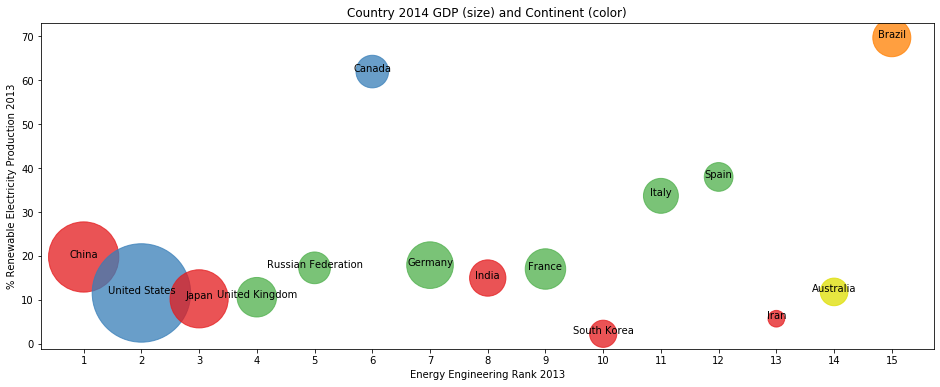

In [21]:
def plot_optional():
    %matplotlib inline
    Top15 = answer_one()
    ax = Top15.plot(x='Rank', y='% Renewable', kind='scatter', 
                    c=['#e41a1c','#377eb8','#e41a1c','#4daf4a','#4daf4a','#377eb8','#4daf4a','#e41a1c',
                       '#4daf4a','#e41a1c','#4daf4a','#4daf4a','#e41a1c','#dede00','#ff7f00'], 
                    xticks=range(1,16), s=6*Top15['2014']/10**10, alpha=.75, figsize=[16,6]);

    for i, txt in enumerate(Top15.index):
        ax.annotate(txt, [Top15['Rank'][i], Top15['% Renewable'][i]], ha='center')
    ax.set_title('Country 2014 GDP (size) and Continent (color)')
    ax.set_xlabel("Energy Engineering Rank 2013")
    ax.set_ylabel("% Renewable Electricity Production 2013")
    print("This bubble chart illustrates a distribution of a categorical and continuous variable along two dimensions of data;")
    print("country's respective continent (color of bubble) and 2014 GDP (size of bubble) across % Renewable vs. Rank dimensions.")
    
    plt.savefig('GDPAndRank.png', bbox_inches='tight')
plot_optional()